In [1]:
!git clone https://github.com/Efromomr/mamba

Cloning into 'mamba'...
remote: Enumerating objects: 765, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (57/57), done.
remote: Total 765 (delta 57), reused 21 (delta 21), pack-reused 687 (from 2)
Receiving objects: 100% (765/765), 1.56 MiB | 11.87 MiB/s, done.
Resolving deltas: 100% (417/417), done.


In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [3]:
%cd /content/mamba

/content/mamba


In [4]:
!pip install causal_conv1d --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.9 MB/s eta 0:00:00


In [5]:
!pip install . --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install datasets pytorch_lightning --quiet

In [6]:
import typing as tp

import torch
import torch.nn as nn
import transformers
from transformers import AutoTokenizer
#from mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from mamba_ssm import Mamba
import matplotlib.pyplot as plt
def normalize_attn_mat(attn_mat):
    return (attn_mat - torch.min(attn_mat)) / (torch.max(attn_mat) - torch.min(attn_mat))

from datasets import *
from feedforward import *
from layernorm import *
from model import *
from pl_module import *

In [11]:
SwiGLU_cfg = {'dim': 128, 'dim_inner': 'null', 'drop_rate': 0, 'bias': False}
Mamba_cfg = {'dim': 128, 'd_state': 16, 'd_conv': 4, 'expand': 2}

In [15]:
from datasets import load_dataset

In [16]:
dataset = load_dataset('stanfordnlp/imdb')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [17]:
from pytorch_lightning import Trainer

tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased')

dataset = load_dataset('stanfordnlp/imdb')

train_dataset = ImdbDataset(notes=dataset['train']['text'],
    targets=dataset['train']['label'],
    tokenizer=tokenizer,
    max_len=128)
test_dataset = ImdbDataset(notes=dataset['test']['text'],
    targets=dataset['test']['label'],
    tokenizer=tokenizer,
    max_len=128)

train_dl = DataLoader(
        dataset=train_dataset,
        batch_size=4,
        shuffle=True,
    )

test_dl = DataLoader(
        dataset=test_dataset,
        batch_size=4,
        shuffle=False
    )

config = {'batch_size': 4,
    'epochs': 200,
    'lr': 5e-4,
    'weight_decay': 0.,
    'min_lr': 1e-6,}

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [18]:
model = LanguageModel(vocab_size = tokenizer.vocab_size, layers = [Mamba, SwiGLU, Mamba, SwiGLU],
                      layer_cfgs = [Mamba_cfg, SwiGLU_cfg, Mamba_cfg, SwiGLU_cfg])


pl_model = PLModelWrap(model=model, config = config)
trainer = Trainer(max_epochs=5, accelerator = 'gpu',
                  callbacks=[pl.callbacks.EarlyStopping(monitor="test/Loss_epoch", mode="min"),
                             pl.callbacks.ModelCheckpoint(
                            save_top_k=1,
                            monitor="test/Loss_epoch",
                            mode="min",
                            dirpath=os.path.join('/content', 'checkpoints'),
                            filename="best", )])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(pl_model, train_dl, test_dl)


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/optimizer.py:378: Found unsupported keys in the optimizer configuration: {'scheduler'}
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | LanguageModel    | 4.4 M  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.644    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [56]:
pl_model.model.model[0][1].compute_attn = True
pl_model.model.model[2][1].compute_attn = True

In [32]:
prompt = 'I love music and films.'

In [57]:
input_tensor = tokenizer(prompt, return_tensors="pt")['input_ids'].cuda()
model = pl_model.model.cuda()
out = model(input_tensor)

In [35]:
pl_model.model.model[0][1].attn_matrices[0].shape

torch.Size([1, 256, 8, 8])

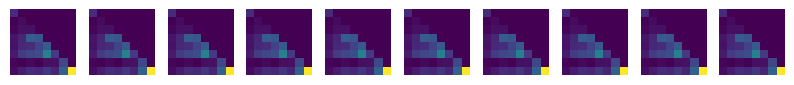

In [58]:
fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    curr_attn_mat = normalize_attn_mat(pl_model.model.model[0][1].attn_matrices[0].mean(dim=1).squeeze().abs())
    axs[i].imshow(curr_attn_mat.cpu().detach().numpy())
    axs[i].axis('off')

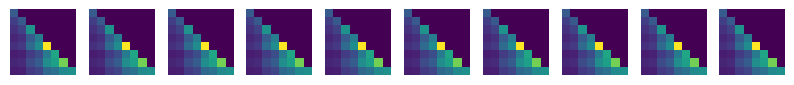

In [59]:
fig, axs = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    curr_attn_mat = normalize_attn_mat(pl_model.model.model[2][1].attn_matrices[0].mean(dim=1).squeeze().abs())
    axs[i].imshow(curr_attn_mat.cpu().detach().numpy())
    axs[i].axis('off')